# Ice Objects Detection using CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
#import pretrainedmodels
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.vision.models.cadene_models import *
from fastai.callbacks import *
import sys
import seaborn as sns
import os
from PIL import Image, ImageStat
import itertools
from fastai.callbacks.tensorboard import LearnerTensorboardWriter
from torch.utils.data.sampler import WeightedRandomSampler

In [3]:
bs = 32

In [4]:
path = Path('.')

In [5]:
import fastai
fastai.__version__

'1.0.57'

## Data augmentation

In [6]:
crop = zoom_crop(scale=(1,1.2), do_rand=True)
tfms = get_transforms(max_rotate=20, max_warp=0., max_zoom=1.2, max_lighting=0.3)

In [7]:
df = pd.read_csv(path/'merged2.csv')

In [8]:
df.head()

,id,categories
0,test_2,floeice brashice
1,test_3,floeice brashice
2,test_4,floeice brashice levelice
3,test_5,floeice iceridge
4,test_6,floeice brashice


In [9]:
df.shape

(404, 2)

In [10]:
np.random.seed(2)
rand_idx = np.random.permutation(range_of(df))
cut = int(0.3 * len(df))
valid_idx = rand_idx[:cut]
train_idx = rand_idx[cut:]
tcut = int(0.33 * len(valid_idx))
test_idx = valid_idx[:tcut]
valid_idx = valid_idx[tcut:]
cut,tcut,rand_idx.shape,train_idx.shape, valid_idx.shape, test_idx.shape

(121, 39, (404,), (283,), (82,), (39,))

In [11]:
trn_df = df.iloc[train_idx]
val_df = df.iloc[valid_idx]
test_df = df.iloc[test_idx]
trn_df.shape,val_df.shape, test_df.shape

((283, 2), (82, 2), (39, 2))

#### Oversample under repersented classes in training set

In [12]:
def normalize(df, cat, cnt):
    cdf = df[[cat in c for c in df.categories.values]]
    additional_rows = cdf.sample(cnt, replace=True)
    return pd.concat((df, additional_rows))

In [13]:
# Under repersented classes
for cat in ['pancake', 'icefloe', 'floeberg', 'floebit', 'berg']:
    trn_df = normalize(trn_df, cat, 50)

In [14]:
trn_df.shape,val_df.shape, test_df.shape

((533, 2), (82, 2), (39, 2))

In [15]:
trn_df = trn_df.reindex()
val_df = val_df.reindex()
test_df = test_df.reindex()

Create imagelists to be used by FastAI databunch API

In [16]:
trn_img = ImageList.from_df(trn_df, path, cols='id', folder='iceobjects_og_test', suffix='.jpg')
val_img = ImageList.from_df(val_df, path, cols='id', folder='iceobjects_og_test', suffix='.jpg')
test_img = ImageList.from_df(test_df, path, cols='id', folder='iceobjects_og_test', suffix='.jpg')

In [17]:
src = ImageList.from_df(df, path, cols='id', folder='iceobjects_og_test', suffix='.jpg').split_by_rand_pct(0.3, seed=2)
src.train = trn_img
src.valid = val_img

In [18]:
def get_data(size, bs):
    return (src.label_from_df(label_delim=' ', cols='categories')
           .transform(tfms, size=size)
           .databunch(bs=bs, num_workers=8).normalize(imagenet_stats))

In [19]:
data = get_data(64, bs)

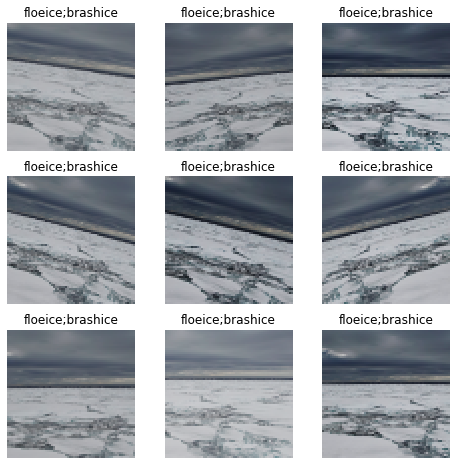

In [20]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

Custom metrics function to diplay progress during training

In [21]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.5, beta=2)

#### Train using models listed below
models.resnet18, models.resnet34, models.resnet50, se_resnet50, xception_cadene, inceptionv4, inceptionresnetv2

In [22]:
for m in [models.resnet18, models.resnet34, models.resnet50, se_resnet50, xception_cadene, inceptionv4, inceptionresnetv2]:
    learn = cnn_learner(data, m, metrics=[acc_05, f_score], ps=[0.1, 0.2, 0.5])
    learn.callbacks += [SaveModelCallback(learn, every='improvement', monitor='fbeta', name=f"{m.__name__}_best")]
    szl = [224, 299]
    print(f"Training using {m.__name__}")
    for sz in szl:
        print(f"Using image size: {sz} ")
        learn.data = get_data(sz,32)
        learn.freeze() # Freeze all the layers of our neural network except top layer
        learn.fit_one_cycle(12, max_lr=slice(1e-2), wd=0.2)
        learn.unfreeze() # Unfreeze pretrained layers to fine tune the weights for our problem
        learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-3), wd=0.1)
        learn.save(f"{m.__name__+str(sz)}")

Training using resnet18
Using image size: 224 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.688271,0.632821,0.630081,0.630101,00:15
1,0.538566,0.407716,0.822493,0.650642,00:15
2,0.386220,0.330406,0.869919,0.549981,00:13
3,0.292744,0.364523,0.872629,0.526065,00:17
4,0.234700,0.340836,0.876694,0.585827,00:16
5,0.189690,0.324428,0.884824,0.587660,00:14
6,0.158568,0.325940,0.890244,0.610070,00:15
7,0.132315,0.306783,0.886179,0.613123,00:14
8,0.110151,0.298842,0.890244,0.633403,00:15
9,0.093815,0.305304,0.892954,0.602952,00:14


Better model found at epoch 0 with fbeta value: 0.6301005482673645.
Better model found at epoch 1 with fbeta value: 0.6506423950195312.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.265547,0.379636,0.841463,0.632282,00:17
1,0.250703,0.329681,0.867209,0.654389,00:14
2,0.217831,0.306597,0.876694,0.632938,00:14
3,0.187746,0.292179,0.875339,0.587325,00:13
4,0.161896,0.278416,0.890244,0.636694,00:14
5,0.142724,0.276440,0.890244,0.624834,00:15
6,0.126479,0.273618,0.891599,0.626867,00:15
7,0.116706,0.276241,0.888889,0.618736,00:17


Better model found at epoch 0 with fbeta value: 0.6322823762893677.
Better model found at epoch 1 with fbeta value: 0.6543891429901123.
Using image size: 299 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.212308,0.316710,0.869919,0.561761,00:17
1,0.180674,0.338897,0.869919,0.528828,00:17
2,0.154898,0.369204,0.888889,0.618099,00:15
3,0.137709,0.397833,0.886179,0.642754,00:16
4,0.122017,0.364912,0.880759,0.605575,00:15
5,0.106826,0.326192,0.892954,0.647637,00:15
6,0.092311,0.329472,0.891599,0.651994,00:15
7,0.081180,0.293013,0.899729,0.671393,00:17
8,0.071394,0.296899,0.905149,0.679840,00:15
9,0.062969,0.299339,0.906504,0.696997,00:15


Better model found at epoch 0 with fbeta value: 0.5617613792419434.
Better model found at epoch 2 with fbeta value: 0.6180993914604187.
Better model found at epoch 3 with fbeta value: 0.6427536010742188.
Better model found at epoch 5 with fbeta value: 0.647636890411377.
Better model found at epoch 6 with fbeta value: 0.6519944071769714.
Better model found at epoch 7 with fbeta value: 0.6713929772377014.
Better model found at epoch 8 with fbeta value: 0.6798397898674011.
Better model found at epoch 9 with fbeta value: 0.6969974637031555.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.039807,0.298884,0.905149,0.672484,00:16
1,0.038115,0.300280,0.903794,0.698550,00:17
2,0.032047,0.305654,0.901084,0.673065,00:16
3,0.031930,0.314266,0.910569,0.674546,00:17
4,0.029487,0.307984,0.909214,0.677301,00:15
5,0.026685,0.304943,0.905149,0.672532,00:16
6,0.025731,0.306353,0.905149,0.676043,00:16
7,0.024680,0.301989,0.909214,0.683742,00:16


Better model found at epoch 0 with fbeta value: 0.6724840402603149.
Better model found at epoch 1 with fbeta value: 0.6985502243041992.
Training using resnet34
Using image size: 224 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.688806,0.644354,0.635501,0.647645,00:15
1,0.541132,0.378160,0.836043,0.703956,00:13
2,0.381592,0.308929,0.876694,0.527215,00:15
3,0.284975,0.310056,0.884824,0.595026,00:16
4,0.223631,0.334425,0.883469,0.601813,00:15
5,0.178124,0.302486,0.884824,0.581325,00:17
6,0.148181,0.294000,0.894309,0.641571,00:17
7,0.124515,0.304418,0.902439,0.658851,00:16
8,0.103364,0.306971,0.899729,0.641659,00:14
9,0.085764,0.291931,0.902439,0.660023,00:15


Better model found at epoch 0 with fbeta value: 0.647644579410553.
Better model found at epoch 1 with fbeta value: 0.7039555311203003.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.257995,0.351492,0.864499,0.703978,00:14
1,0.237839,0.308769,0.883469,0.678313,00:14
2,0.205412,0.286820,0.883469,0.621899,00:15
3,0.174022,0.270143,0.891599,0.618618,00:17
4,0.146211,0.262944,0.895664,0.621935,00:14
5,0.125789,0.262102,0.903794,0.647054,00:13
6,0.110924,0.263464,0.899729,0.622612,00:14
7,0.099674,0.265970,0.895664,0.608384,00:14


Better model found at epoch 0 with fbeta value: 0.7039777040481567.
Using image size: 299 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.245525,0.326381,0.872629,0.636236,00:15
1,0.203137,0.336516,0.867209,0.486696,00:17
2,0.168057,0.325749,0.884824,0.622891,00:16
3,0.145950,0.322679,0.891599,0.704486,00:15
4,0.125023,0.335331,0.888889,0.661002,00:15
5,0.108932,0.310903,0.894309,0.674178,00:16
6,0.095016,0.297205,0.899729,0.662899,00:17
7,0.081000,0.313735,0.905149,0.696826,00:17
8,0.069004,0.315831,0.903794,0.663540,00:17
9,0.061445,0.326888,0.903794,0.673648,00:15


Better model found at epoch 0 with fbeta value: 0.6362358927726746.
Better model found at epoch 3 with fbeta value: 0.7044858932495117.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095339,0.303669,0.894309,0.671112,00:16
1,0.082665,0.298599,0.894309,0.660124,00:16
2,0.071245,0.279384,0.902439,0.689732,00:15
3,0.061253,0.269435,0.910569,0.716528,00:14
4,0.052594,0.281616,0.910569,0.706581,00:15
5,0.045870,0.281901,0.910569,0.704302,00:15
6,0.041550,0.281088,0.909214,0.713989,00:15
7,0.037635,0.281382,0.906504,0.687611,00:15


Better model found at epoch 0 with fbeta value: 0.6711121201515198.
Better model found at epoch 2 with fbeta value: 0.6897323131561279.
Better model found at epoch 3 with fbeta value: 0.7165282368659973.
Training using resnet50
Using image size: 224 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.624065,0.582152,0.714092,0.683919,00:17
1,0.482185,0.424399,0.823848,0.724035,00:14
2,0.340401,0.302298,0.887534,0.626940,00:17
3,0.253146,0.313780,0.884824,0.682859,00:18
4,0.194898,0.349586,0.886179,0.680353,00:15
5,0.153409,0.322707,0.892954,0.677016,00:16
6,0.123579,0.329323,0.899729,0.664188,00:14
7,0.100266,0.303445,0.901084,0.701444,00:16
8,0.082335,0.297754,0.891599,0.691561,00:15
9,0.067828,0.300872,0.892954,0.680088,00:14


Better model found at epoch 0 with fbeta value: 0.6839190721511841.
Better model found at epoch 1 with fbeta value: 0.7240353226661682.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.234984,0.362308,0.852304,0.662950,00:14
1,0.208899,0.307868,0.887534,0.709387,00:13
2,0.179634,0.290904,0.894309,0.731300,00:15
3,0.148376,0.294147,0.886179,0.664294,00:18
4,0.123813,0.282688,0.887534,0.629495,00:16
5,0.106445,0.281519,0.890244,0.636173,00:14
6,0.090678,0.284460,0.890244,0.643529,00:15
7,0.080339,0.283448,0.887534,0.640388,00:14


Better model found at epoch 0 with fbeta value: 0.6629502177238464.
Better model found at epoch 1 with fbeta value: 0.7093868851661682.
Better model found at epoch 2 with fbeta value: 0.7313004732131958.
Using image size: 299 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.127948,0.275744,0.897019,0.668002,00:17
1,0.105053,0.294622,0.895664,0.666822,00:16
2,0.102052,0.369534,0.878049,0.724065,00:17
3,0.093679,0.296104,0.905149,0.720900,00:18
4,0.082806,0.285011,0.914634,0.787594,00:17
5,0.070054,0.323555,0.902439,0.691200,00:15
6,0.060379,0.339379,0.910569,0.729988,00:17
7,0.053888,0.308355,0.909214,0.719588,00:17
8,0.046000,0.307011,0.913279,0.732461,00:16
9,0.038071,0.297220,0.914634,0.736772,00:15


Better model found at epoch 0 with fbeta value: 0.668002188205719.
Better model found at epoch 2 with fbeta value: 0.7240652441978455.
Better model found at epoch 4 with fbeta value: 0.7875939607620239.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.046432,0.281453,0.914634,0.758003,00:19
1,0.038691,0.302658,0.910569,0.720429,00:16
2,0.035228,0.283595,0.909214,0.744483,00:16
3,0.029667,0.298271,0.909214,0.715493,00:15
4,0.026876,0.286842,0.921409,0.775874,00:17
5,0.024634,0.298227,0.910569,0.718189,00:18
6,0.022419,0.310882,0.910569,0.723244,00:16
7,0.019967,0.299400,0.907859,0.709738,00:17


Better model found at epoch 0 with fbeta value: 0.7580029368400574.
Better model found at epoch 4 with fbeta value: 0.7758739590644836.
Training using se_resnet50
Using image size: 224 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.614276,0.700433,0.643631,0.625681,00:15
1,0.483619,0.404464,0.830623,0.658622,00:15
2,0.334224,0.317398,0.890244,0.632913,00:15
3,0.247020,0.356970,0.888889,0.596605,00:16
4,0.192389,0.330599,0.884824,0.608935,00:15
5,0.153591,0.358629,0.890244,0.608417,00:15
6,0.123314,0.360910,0.884824,0.547217,00:14
7,0.102464,0.343572,0.899729,0.639969,00:15
8,0.085315,0.347635,0.898374,0.603682,00:15
9,0.070965,0.342815,0.897019,0.618825,00:15


Better model found at epoch 0 with fbeta value: 0.6256808638572693.
Better model found at epoch 1 with fbeta value: 0.6586224436759949.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.228258,0.359558,0.859079,0.648645,00:15
1,0.205072,0.313963,0.882114,0.683320,00:15
2,0.171175,0.290595,0.894309,0.676196,00:14
3,0.138719,0.277237,0.902439,0.660146,00:16
4,0.115333,0.279361,0.894309,0.630916,00:14
5,0.095694,0.283664,0.903794,0.647854,00:16
6,0.085363,0.286237,0.901084,0.634304,00:15
7,0.075298,0.282713,0.902439,0.645963,00:15


Better model found at epoch 0 with fbeta value: 0.648645281791687.
Better model found at epoch 1 with fbeta value: 0.6833195090293884.
Using image size: 299 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.161382,0.294143,0.897019,0.639350,00:16
1,0.131874,0.298373,0.898374,0.654704,00:17
2,0.115636,0.390516,0.879404,0.620179,00:15
3,0.101127,0.318601,0.899729,0.676595,00:17
4,0.090921,0.323443,0.879404,0.638436,00:16
5,0.079393,0.322314,0.895664,0.678661,00:17
6,0.069779,0.313755,0.895664,0.639455,00:17
7,0.059847,0.321433,0.892954,0.631951,00:20
8,0.049540,0.314284,0.901084,0.673488,00:16
9,0.042660,0.321260,0.899729,0.671886,00:16


Better model found at epoch 0 with fbeta value: 0.6393500566482544.
Better model found at epoch 1 with fbeta value: 0.654703676700592.
Better model found at epoch 3 with fbeta value: 0.676595151424408.
Better model found at epoch 5 with fbeta value: 0.6786614656448364.
Better model found at epoch 11 with fbeta value: 0.6807832717895508.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.019943,0.303690,0.905149,0.677306,00:18
1,0.018283,0.301391,0.907859,0.684804,00:16
2,0.017992,0.331228,0.906504,0.671931,00:16
3,0.018558,0.329134,0.899729,0.636016,00:15
4,0.016152,0.338278,0.897019,0.648122,00:18
5,0.015279,0.330657,0.901084,0.663951,00:20
6,0.013394,0.333371,0.905149,0.673911,00:17
7,0.012760,0.330493,0.903794,0.678073,00:17


Better model found at epoch 0 with fbeta value: 0.6773064732551575.
Better model found at epoch 1 with fbeta value: 0.6848037242889404.
Training using xception_cadene
Using image size: 224 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.683547,0.639698,0.695122,0.476138,00:14
1,0.591901,0.461418,0.813008,0.395662,00:15
2,0.487618,0.432722,0.817073,0.196057,00:15
3,0.418366,0.392570,0.826558,0.232080,00:15
4,0.374991,0.357807,0.838753,0.302638,00:16
5,0.333149,0.348802,0.848239,0.378324,00:15
6,0.300198,0.329284,0.871274,0.493624,00:17
7,0.266820,0.317336,0.876694,0.533184,00:16
8,0.240262,0.307761,0.887534,0.573782,00:14
9,0.220442,0.307885,0.882114,0.590050,00:16


Better model found at epoch 0 with fbeta value: 0.4761384129524231.
Better model found at epoch 6 with fbeta value: 0.4936242401599884.
Better model found at epoch 7 with fbeta value: 0.5331836938858032.
Better model found at epoch 8 with fbeta value: 0.5737819075584412.
Better model found at epoch 9 with fbeta value: 0.5900495648384094.
Better model found at epoch 10 with fbeta value: 0.6109033226966858.
Better model found at epoch 11 with fbeta value: 0.6204398274421692.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.139901,0.301237,0.892954,0.631914,00:14
1,0.141679,0.294171,0.890244,0.619429,00:15
2,0.136351,0.307127,0.886179,0.612486,00:16
3,0.133211,0.294769,0.897019,0.649873,00:18
4,0.122769,0.294362,0.895664,0.632881,00:15
5,0.116165,0.290851,0.891599,0.618319,00:15
6,0.109886,0.290134,0.895664,0.627409,00:15
7,0.104281,0.294376,0.897019,0.642366,00:14


Better model found at epoch 0 with fbeta value: 0.6319141983985901.
Better model found at epoch 3 with fbeta value: 0.6498725414276123.
Using image size: 299 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.158579,0.322423,0.884824,0.570357,00:18
1,0.157272,0.287346,0.899729,0.629441,00:17
2,0.158447,0.371280,0.871274,0.465723,00:17
3,0.165617,0.366029,0.871274,0.543585,00:18
4,0.171259,0.295785,0.895664,0.589610,00:22
5,0.158129,0.311972,0.892954,0.585932,00:15
6,0.149142,0.315029,0.886179,0.599447,00:16
7,0.142639,0.291618,0.894309,0.616376,00:15
8,0.132741,0.320941,0.890244,0.609364,00:16
9,0.124131,0.288202,0.897019,0.650452,00:17


Better model found at epoch 0 with fbeta value: 0.5703571438789368.
Better model found at epoch 1 with fbeta value: 0.6294410228729248.
Better model found at epoch 9 with fbeta value: 0.6504524946212769.
Better model found at epoch 11 with fbeta value: 0.6660352349281311.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083940,0.279842,0.905149,0.681230,00:16
1,0.084049,0.274707,0.907859,0.677254,00:16
2,0.077479,0.286643,0.901084,0.658284,00:17
3,0.075088,0.278790,0.902439,0.674121,00:17
4,0.071601,0.292791,0.906504,0.682616,00:16
5,0.066619,0.278942,0.909214,0.689703,00:16
6,0.061802,0.281319,0.911924,0.707222,00:17
7,0.058707,0.281612,0.906504,0.682199,00:17


Better model found at epoch 0 with fbeta value: 0.6812300086021423.
Better model found at epoch 4 with fbeta value: 0.6826162934303284.
Better model found at epoch 5 with fbeta value: 0.6897032856941223.
Better model found at epoch 6 with fbeta value: 0.7072216868400574.
Training using inceptionv4
Using image size: 224 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.692863,0.668390,0.631436,0.554198,00:16
1,0.564402,0.491186,0.784553,0.588844,00:16
2,0.423794,0.481128,0.833333,0.453143,00:15
3,0.336201,0.518385,0.823848,0.477852,00:16
4,0.284622,0.384129,0.849594,0.515899,00:15
5,0.242100,0.378773,0.856369,0.513028,00:15
6,0.207629,0.400961,0.848239,0.479427,00:15
7,0.180660,0.379363,0.871274,0.568098,00:15
8,0.160242,0.367715,0.863144,0.526987,00:15
9,0.142681,0.388655,0.861789,0.556297,00:16


Better model found at epoch 0 with fbeta value: 0.5541982054710388.
Better model found at epoch 1 with fbeta value: 0.5888436436653137.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.312095,0.485719,0.800813,0.557658,00:14
1,0.287755,0.382002,0.840108,0.529391,00:16
2,0.254384,0.349934,0.861789,0.540856,00:16
3,0.219519,0.351727,0.864499,0.545036,00:16
4,0.190838,0.338807,0.867209,0.534041,00:15
5,0.168640,0.351140,0.868564,0.580475,00:16
6,0.151987,0.326829,0.880759,0.575046,00:17
7,0.136266,0.323526,0.879404,0.568355,00:18


Better model found at epoch 0 with fbeta value: 0.5576581954956055.
Better model found at epoch 5 with fbeta value: 0.5804749131202698.
Using image size: 299 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.136749,0.318529,0.875339,0.589400,00:18
1,0.127445,0.374470,0.872629,0.583308,00:16
2,0.125375,0.421437,0.852304,0.583887,00:16
3,0.124360,0.412376,0.871274,0.639852,00:16
4,0.115930,0.367760,0.882114,0.615601,00:17
5,0.104683,0.343882,0.882114,0.602658,00:18
6,0.095882,0.373064,0.884824,0.586047,00:15
7,0.085113,0.332737,0.898374,0.659028,00:19
8,0.074583,0.328222,0.892954,0.655447,00:18
9,0.065780,0.348850,0.888889,0.635204,00:17


Better model found at epoch 0 with fbeta value: 0.5893996357917786.
Better model found at epoch 3 with fbeta value: 0.6398516893386841.
Better model found at epoch 7 with fbeta value: 0.6590275764465332.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.054956,0.333800,0.895664,0.652588,00:16
1,0.049215,0.334219,0.891599,0.637481,00:18
2,0.043875,0.346524,0.888889,0.637110,00:16
3,0.037834,0.349966,0.898374,0.645270,00:18
4,0.038340,0.349545,0.898374,0.672238,00:18
5,0.033242,0.343977,0.898374,0.679445,00:19
6,0.030011,0.345613,0.897019,0.673920,00:18
7,0.027939,0.344566,0.898374,0.666185,00:19


Better model found at epoch 0 with fbeta value: 0.6525875329971313.
Better model found at epoch 4 with fbeta value: 0.6722383499145508.
Better model found at epoch 5 with fbeta value: 0.6794445514678955.
Training using inceptionresnetv2
Using image size: 224 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.675377,0.719877,0.649051,0.556401,00:17
1,0.552881,0.482414,0.804878,0.539419,00:16
2,0.422730,0.423888,0.834688,0.476888,00:16
3,0.343303,0.450794,0.827913,0.487145,00:16
4,0.290295,0.413145,0.850948,0.552702,00:15
5,0.245549,0.405408,0.853659,0.538335,00:16
6,0.209192,0.426929,0.842818,0.522005,00:18
7,0.180749,0.424627,0.853659,0.512370,00:15
8,0.156427,0.429912,0.853659,0.499884,00:15
9,0.139400,0.442220,0.852304,0.518776,00:15


Better model found at epoch 0 with fbeta value: 0.5564014315605164.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.531464,0.634344,0.661247,0.595730,00:18
1,0.503071,0.571339,0.735772,0.644246,00:19
2,0.461952,0.496236,0.781843,0.625917,00:17
3,0.397685,0.418321,0.826558,0.631228,00:16
4,0.342447,0.379471,0.842818,0.604717,00:17
5,0.293411,0.357926,0.853659,0.595730,00:17
6,0.256833,0.352636,0.856369,0.600719,00:18
7,0.230444,0.354935,0.853659,0.594067,00:18


Better model found at epoch 0 with fbeta value: 0.595730185508728.
Better model found at epoch 1 with fbeta value: 0.6442456841468811.
Using image size: 299 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.438620,0.481344,0.794038,0.676577,00:20
1,0.360457,0.378438,0.850949,0.582889,00:18
2,0.283889,0.382831,0.868564,0.628644,00:19
3,0.233498,0.417910,0.855014,0.598142,00:19
4,0.198199,0.353475,0.884824,0.635292,00:20
5,0.170267,0.331637,0.884824,0.620739,00:20
6,0.149535,0.333222,0.879404,0.584331,00:17
7,0.126997,0.327108,0.899729,0.668059,00:18
8,0.105575,0.318499,0.901084,0.638391,00:17
9,0.093240,0.316736,0.902439,0.655605,00:18


Better model found at epoch 0 with fbeta value: 0.6765772104263306.


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.369971,0.482015,0.783198,0.665615,00:19
1,0.337190,0.422282,0.837398,0.707252,00:21
2,0.294638,0.344268,0.871274,0.704924,00:20
3,0.248180,0.309525,0.880759,0.698806,00:19
4,0.205211,0.292233,0.886179,0.676932,00:19
5,0.174760,0.285067,0.883469,0.647245,00:19
6,0.148792,0.284012,0.888889,0.665247,00:19
7,0.130865,0.285076,0.888889,0.649515,00:19


Better model found at epoch 0 with fbeta value: 0.6656146049499512.
Better model found at epoch 1 with fbeta value: 0.7072515487670898.


#### Load the best model

In [37]:
data = get_data(299, 32)
learn = cnn_learner(data, models.resnet50, metrics=[acc_05, f_score], ps=[0.1, 0.2, 0.5])
learn.load('resnet50299');

### Model Interpretation

In [38]:
interop = ClassificationInterpretation.from_learner(learn)

In [39]:
img = data.valid_ds[1][0]

torch.Size([3, 299, 299])

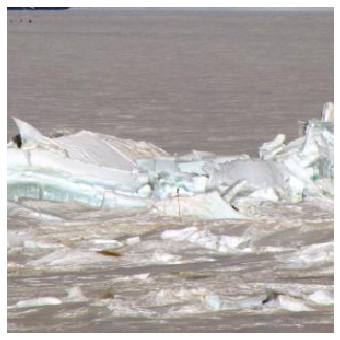

In [84]:
show_image(img, figsize=(6,6));img.shape

In [85]:
learn.predict(img)

(MultiCategory iceridge;levelice,
 tensor([0., 0., 0., 0., 0., 0., 1., 1., 0.]),
 tensor([0.0030, 0.0021, 0.0351, 0.0204, 0.0086, 0.0600, 0.9698, 0.7008, 0.0281]))

In [42]:
preds,y = learn.get_preds()

In [43]:
fnames = [ f.split('/')[2] for f in data.valid_ds.x.items]

In [44]:
data.classes

['berg',
 'brashice',
 'floeberg',
 'floebit',
 'floeice',
 'icefloe',
 'iceridge',
 'levelice',
 'pancake']

(tensor([1.1132e-02, 9.8766e-01, 2.4132e-02, 9.5719e-03, 9.9831e-01, 6.0309e-05,
         3.8774e-03, 2.9692e-04, 7.5861e-06]), 'floe_ice_46.jpg')

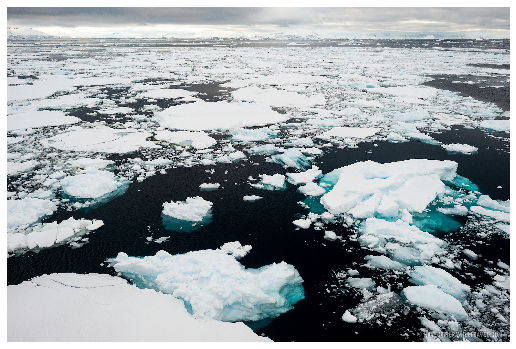

In [47]:
idx=11
show_image(open_image(path/'iceobjects_og_test'/fnames[idx]), figsize=(9,9)); preds[idx], fnames[idx]

## Confustion Matrix

In [62]:
from sklearn.metrics import confusion_matrix

In [63]:
preds,y, loss = learn.get_preds(with_loss=True)

In [64]:
def multi_class_confusion(y_true, y_pred, labels=None):
    confusion_mat = {}
    for i in range(len(y_true[0])): 
        if labels is not None:
            confusion_mat[labels[i]] = confusion_matrix(y_true[:,i], y_pred[:,i])
        else:
            confusion_mat[i] = confusion_matrix(y_true[:,i], y_pred[:,i])
    
    return confusion_mat

In [65]:
mat = multi_class_confusion(y, preds >0.9, data.classes)

In [66]:
for label, matrix in mat.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label berg:
[[70  0]
 [ 7  5]]
Confusion matrix for label brashice:
[[58  0]
 [14 10]]
Confusion matrix for label floeberg:
[[78  0]
 [ 4  0]]
Confusion matrix for label floebit:
[[72  0]
 [ 9  1]]
Confusion matrix for label floeice:
[[48  1]
 [11 22]]
Confusion matrix for label icefloe:
[[78  0]
 [ 3  1]]
Confusion matrix for label iceridge:
[[41  2]
 [11 28]]
Confusion matrix for label levelice:
[[60  1]
 [14  7]]
Confusion matrix for label pancake:
[[75  0]
 [ 4  3]]


## Predictions for test dataset

In [67]:
preds = []
for i in test_img:
    preds.append(learn.predict(i))

In [68]:
len(preds)

39

((MultiCategory brashice;floeice,
  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]),
  tensor([7.9883e-03, 9.9884e-01, 2.6070e-05, 3.6452e-05, 9.9874e-01, 1.0375e-01,
          1.3050e-03, 4.8861e-04, 2.8575e-04])),
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd4b5b09a90>)

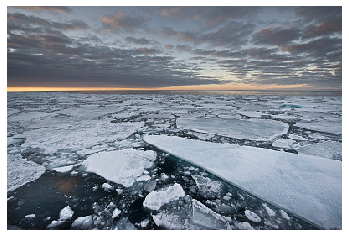

In [77]:
preds[0], show_image(test_img[0], figsize=(6,6))

In [70]:
preds

[(MultiCategory brashice;floeice,
  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]),
  tensor([7.9883e-03, 9.9884e-01, 2.6070e-05, 3.6452e-05, 9.9874e-01, 1.0375e-01,
          1.3050e-03, 4.8861e-04, 2.8575e-04])),
 (MultiCategory floeice,
  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  tensor([4.5772e-03, 2.2365e-01, 4.3773e-04, 2.3184e-04, 9.9634e-01, 2.6967e-03,
          7.0538e-02, 1.6355e-03, 5.3129e-04])),
 (MultiCategory levelice,
  tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  tensor([4.8146e-04, 7.9548e-04, 2.3547e-03, 3.6947e-04, 3.2781e-02, 1.8822e-03,
          2.8584e-02, 9.4736e-01, 4.2112e-03])),
 (MultiCategory brashice;floeice,
  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]),
  tensor([4.9421e-03, 8.2233e-01, 4.8295e-04, 4.0584e-03, 9.9704e-01, 7.5965e-03,
          4.3630e-01, 6.0955e-03, 1.4185e-03])),
 (MultiCategory brashice;floeice,
  tensor([0., 1., 0., 0., 1., 0., 0., 0., 0.]),
  tensor([1.1998e-02, 9.9952e-01, 1.0537e-02, 3.2827e-05, 9.9981e-01, 8.4178e-05,
 